In [1]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects

In [2]:
def convert_toGrayImage(filename):
    img = ski.io.imread(filename)
    img = ski.util.img_as_ubyte(img)
    gray_image = rgb2gray(img)
    return gray_image, img

In [3]:
def get_binaryMango(gray_image, sigma=1.0, connectivity = 2):
    blurred_image = ski.filters.gaussian(gray_image, sigma=sigma)
    bin_image = blurred_image > threshold_otsu(blurred_image)
    
    filled_img = binary_fill_holes(bin_image)
    labeled_image, count = ski.measure.label(filled_img, connectivity=connectivity, return_num=True)

    object_features = ski.measure.regionprops(labeled_image)
    object_areas = [objf["area"] for objf in object_features]
    max_size = max(object_areas)

    mango_mask = remove_small_objects(labeled_image, min_size=max_size-1)
    #plt.imshow(mango_mask)
    #plt.show() 

    mango_mask = mango_mask < 1
    return mango_mask
    

In [4]:
def std_image(gray_img, mango_mask):
    mango_mask = ski.util.invert(mango_mask)
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev
     

In [5]:
#Esta función recibe la imagen original de mango en color (mango_img). Recibe la imagen del mango en escala de grises (gray_img), y
#recibe una imagen binaria representando la máscara del mango.
#La funcion crea un dataframe con las siguientes características extraídas de las imagenes que recibe en sus parámetros:
#area: área de la imagen que ocupa la máscara del mango
#max_gray_value: valor máximo de intensidad en escala de grises de la región enmascarada
#min_gray_value: valor mínimo de intensidad en escala de grises de la región enmascarada  
#mean_gray_value: valor medio de intensidad en escala de grises de la región enmascarada  
#mean_value_R: valor medio de intensidad en el canal Red estimado solo en la región enmascarada
#mean_value_G: valor medio de intensidad en el canal Green estimado solo en la región enmascarada
#mean_value_B: valor medio de intensidad en el canal Blue estimado solo en la región enmascarada
#std: desviación estandar de los valores de intensidad de la imagen en escala de grises, estimada solo en la región enmascarada
#Pueden explorar otras propiedades de las imagenes, que pueden ser tomados como atributos en este listado: 
#https://github.com/scikit-image/scikit-image/blob/main/skimage/measure/_regionprops.py

import statistics
import pandas as pd
    
def extract_properties(mango_img, gray_img, mango_mask):

    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    object_features = ski.measure.regionprops(labeled_mango)

    var_color_props = ['intensity_mean']
    color_props = ski.measure.regionprops_table(labeled_mango, mango_img, properties=var_color_props)

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
    
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    
    df_image['mean_value_R'] = color_props['intensity_mean-0'] 
    df_image['mean_value_G'] = color_props['intensity_mean-1'] 
    df_image['mean_value_B'] = color_props['intensity_mean-2']
    df_image['std'] = grayImg_stdev 
    
    print(df_image.head())
    

In [6]:
def intensity_table(grayValues):
    table = {}
    for ival in range(256):
        table['val_'+ str(ival)] = [np.count_nonzero(grayValues == ival)]
       
    df_table = pd.DataFrame.from_dict(table, orient='columns')
    return df_table

In [7]:
#Esta función recibe una imagen en escala de grises y una mascara del objeto de interés en la imagen. Cuenta el número de veces
#que cada valor de intensigdad en el rango (0, 255) se repite en la región de interés enmascarada en la imagen en escala de grises
#Retorna un data frame donde cada columna corresponde a un valor de intensidad, y los valores en las colunmas al número de veces que se repite el valor
#en la región de interés

def hist2features(grayImg, mangoMask):
    #color = ski.util.img_as_ubyte(colorImg)
    gray = ski.util.img_as_ubyte(grayImg)
    mango_mask = ski.util.invert(mangoMask)

    masked_gray = gray * mango_mask
    plt.imshow(masked_gray, cmap = 'gray')
    plt.show()
    df_intensities = intensity_table(masked_gray)
    print(df_intensities)
    return df_intensities
    
    

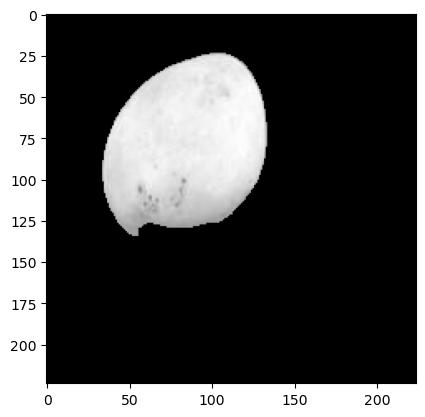

   val_0  val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  ...  \
0  41768      0      0      0      0      0      0      0      0      0  ...   

   val_246  val_247  val_248  val_249  val_250  val_251  val_252  val_253  \
0        0        0        0        0        0        0        0        0   

   val_254  val_255  
0        0        0  

[1 rows x 256 columns]
      area  max_gray_value  min_gray_value  mean_gray_value  mean_value_R  \
0  41031.0        0.977259        0.097198         0.361833     93.620726   

   mean_value_G  mean_value_B       std  
0     91.932124     91.604445  0.103475  


In [8]:
img_file1 = "mango1.jpg"
img_file2 = "mango2.jpg"

grayImg1, img1 = convert_toGrayImage(img_file1)
grayImg2, img2 = convert_toGrayImage(img_file2)

mango_mask1 = get_binaryMango(grayImg1)
mango_mask2 = get_binaryMango(grayImg2)

#Dos opciones para vectorizar las imagenes: podría tomar una de las dos opciones

#  --> opción 1, Cada valor de la escala de grises se toma como una característica de la imagen.
#hist2features(grayImg1, mango_mask1)
hist2features(grayImg2, mango_mask2)

#  --> opción 2, se extraen características de las imagenes utilizando la función regionprops, aquí se extraen algunas propiedades; pero
#      podrían tomarse más características.
extract_properties(img1, grayImg1, mango_mask1)
#extract_properties(img2, grayImg2, mango_mask2)
